
PCA ha ridotto a 200 componenti

 Training LogisticRegression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params for LogisticRegression: {'C': 0.1}
 Val Metrics for LogisticRegression:
  Accuracy:  0.3400
  Precision: 0.3378
  Recall:    0.3400
  F1 Score:  0.3382


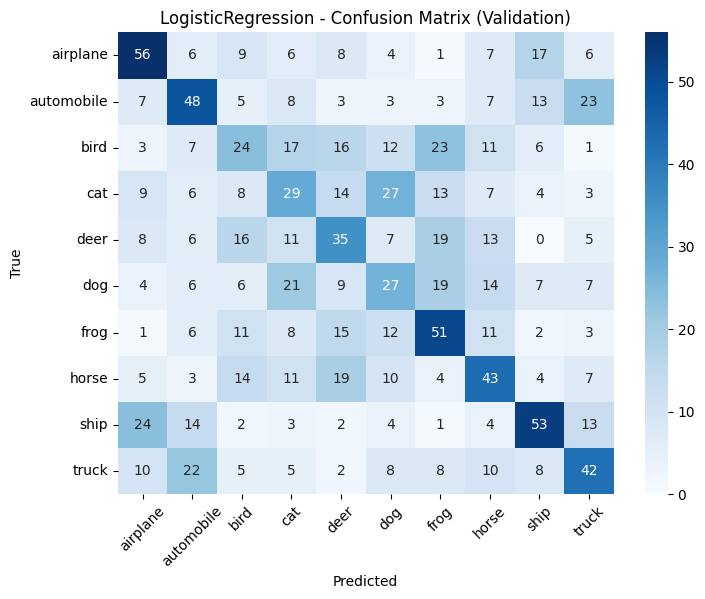


 Training KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params for KNN: {'n_neighbors': 7, 'weights': 'distance'}
 Val Metrics for KNN:
  Accuracy:  0.3133
  Precision: 0.3991
  Recall:    0.3133
  F1 Score:  0.2927


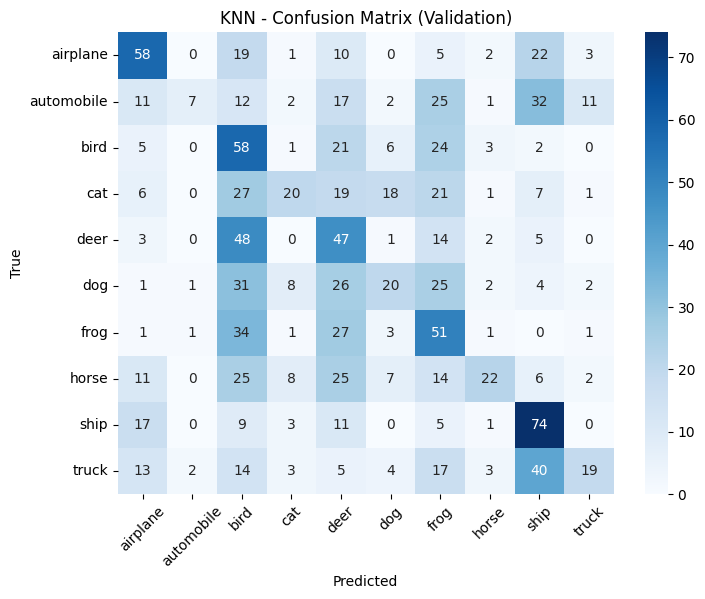


 Training SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params for SVM: {'C': 10, 'kernel': 'rbf'}
 Val Metrics for SVM:
  Accuracy:  0.4392
  Precision: 0.4468
  Recall:    0.4392
  F1 Score:  0.4414


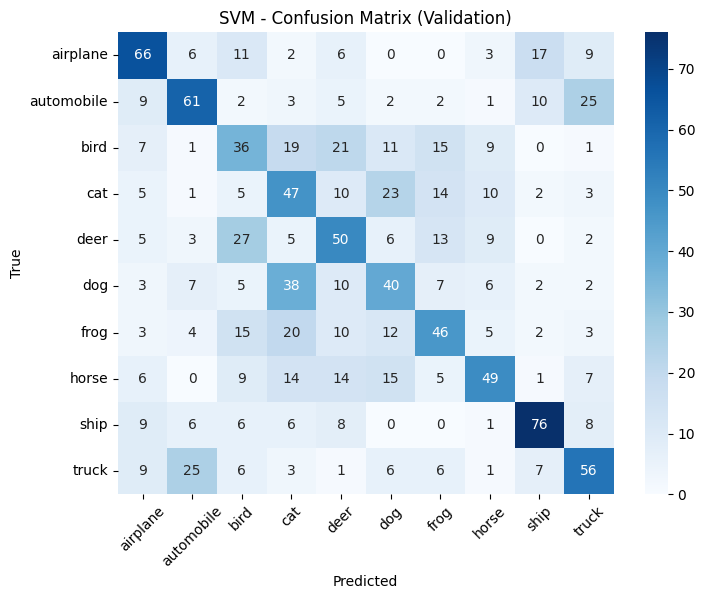


 Training DecisionTree...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for DecisionTree: {'criterion': 'gini', 'max_depth': 20}
 Val Metrics for DecisionTree:
  Accuracy:  0.2817
  Precision: 0.2818
  Recall:    0.2817
  F1 Score:  0.2813


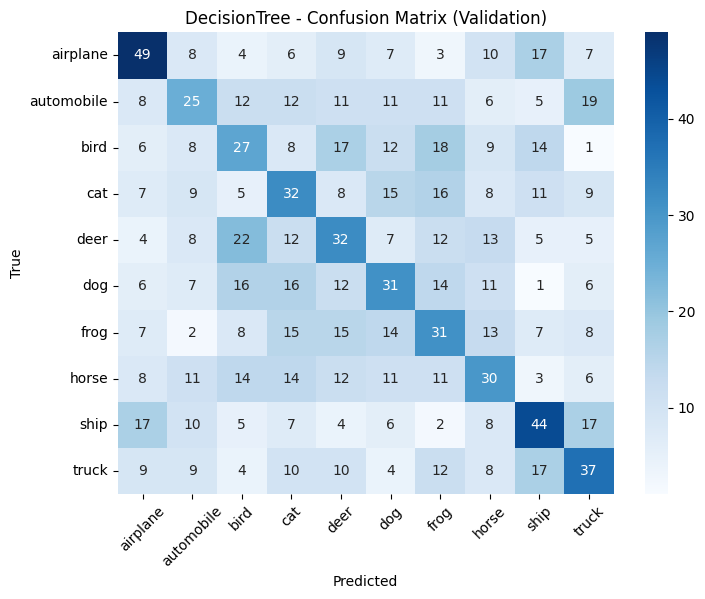


Il miglior modello è SVM con un'accuratezza di validazione di 0.4392

Valutazione Test set (solo modello migliore):

Test Metrics for SVM:
  Accuracy:  0.4500
  Precision: 0.4577
  Recall:    0.4500
  F1 Score:  0.4529


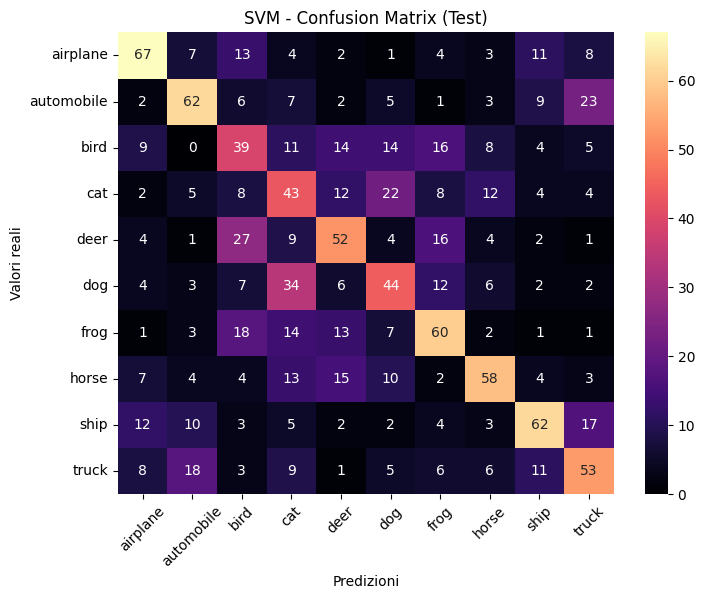


Visualizzazione delle predizioni del miglior modello:


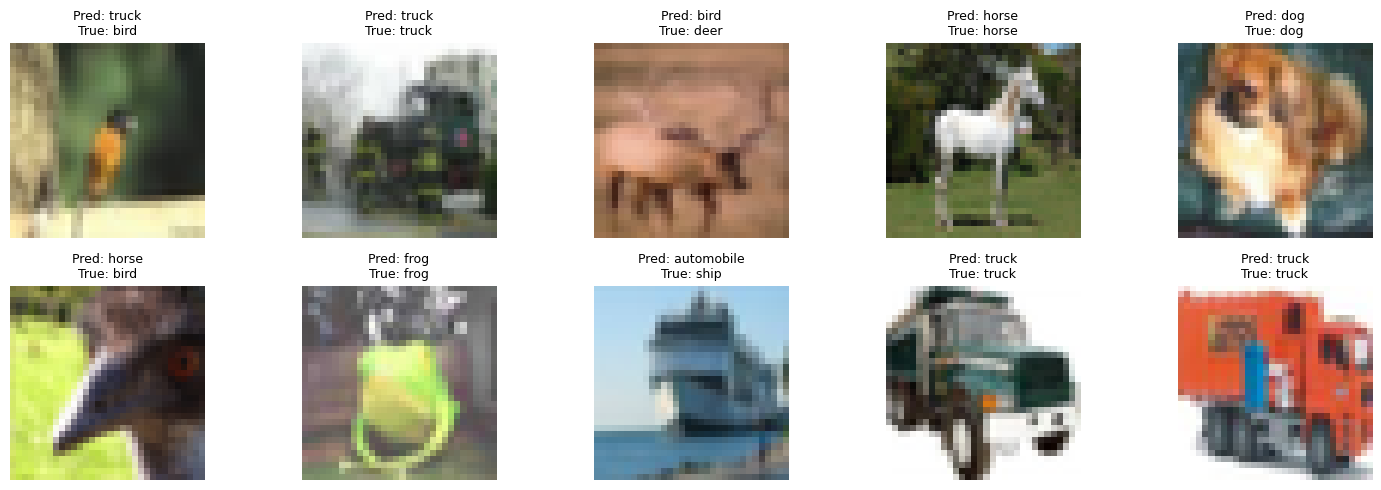

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from tensorflow.keras.datasets import cifar10

# 1. Caricamento CIFAR-10
(X_train_full, y_train_full), (X_test_orig, y_test_orig) = cifar10.load_data()
X = np.concatenate((X_train_full, X_test_orig), axis=0)
y = np.concatenate((y_train_full, y_test_orig), axis=0).flatten()

# Classi del dataset
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 2. Flatten + Normalizzazione immagini
X_flat = X.reshape(X.shape[0], -1) / 255.0  

# 3. Sottocampionamento 
X_subset, y_subset, X_subset_raw = resample(X_flat, y, X, n_samples=6000, random_state=42, stratify=y)

# 4. Split stratificato in 60/20/20 (train/val/test)
X_train, X_temp, y_train, y_temp, X_train_raw, X_temp_raw = train_test_split(
    X_subset, y_subset, X_subset_raw, test_size=0.4, stratify=y_subset, random_state=42
)
X_val, X_test, y_val, y_test, X_val_raw, X_test_raw = train_test_split(
    X_temp, y_temp, X_temp_raw, test_size=0.5, stratify=y_temp, random_state=42
)

# 5. Standardizzazione (fit solo sul training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#PCA - Riduzione dimensionale (95% varianza)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nPCA ha ridotto a {pca.n_components_} componenti")

# 6. Setup modelli
model_configs = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.1, 1, 10]},  # Aggiunto grid search anche per LogisticRegression
        'use_scaling': True
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
        'use_scaling': True
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'use_scaling': True
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, None]},
        'use_scaling': False
    }
}


# 7. GridSearch + valutazione su validation

results = {}
best_model_name = ""
best_model_accuracy = 0.0

for name, config in model_configs.items():
    print(f"\n Training {name}...")

    if config['use_scaling']:
        X_tr = X_train_pca
        X_va = X_val_pca
    else:
        X_tr = X_train_scaled
        X_va = X_val_scaled

    clf = GridSearchCV(config['model'], config['params'], cv=3, n_jobs=-1, verbose=1)
    clf.fit(X_tr, y_train)
    best_model = clf.best_estimator_

    y_pred_val = best_model.predict(X_va)

    # Metriche di validazione singole
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, average='macro')
    val_recall = recall_score(y_val, y_pred_val, average='macro')
    val_f1 = f1_score(y_val, y_pred_val, average='macro')

    print(f"Best Params for {name}: {clf.best_params_}")
    print(f" Val Metrics for {name}:")
    print(f"  Accuracy:  {val_accuracy:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall:    {val_recall:.4f}")
    print(f"  F1 Score:  {val_f1:.4f}")

    results[name] = {
        'model': best_model,
        'cv_score': clf.best_score_,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    }

    if val_accuracy > best_model_accuracy:
        best_model_accuracy = val_accuracy
        best_model_name = name

    # Confusion matrix validation
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_val, y_pred_val), 
                annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

print(f"\nIl miglior modello è {best_model_name} con un'accuratezza di validazione di {best_model_accuracy:.4f}")



    
#SEZIONE 8: Test 
print("\nValutazione Test set (solo modello migliore):")
final_model = results[best_model_name]['model']

if model_configs[best_model_name]['use_scaling']:
    X_te = X_test_pca
else:
    X_te = X_test_scaled

y_pred_test = final_model.predict(X_te)

# Metriche test singole
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro')
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro')

print(f"\nTest Metrics for {best_model_name}:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1 Score:  {test_f1:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), 
            annot=True, fmt='d', cmap="magma",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"{best_model_name} - Confusion Matrix (Test)")
plt.xlabel("Predizioni")
plt.ylabel("Valori reali")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Funzione corretta per visualizzare le predizioni
def show_predictions(model, X_raw, X_processed, y_true, label_map, num_images=10):
    
    if model_configs[best_model_name]['use_scaling']:
        # Se il modello usa PCA
        X_input = scaler.transform(X_processed[:num_images])  
        X_input = pca.transform(X_input)  
    else:
        # Se non usa PCA
        X_input = scaler.transform(X_processed[:num_images])
    
    y_pred = model.predict(X_input)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img = X_raw[i]  
        true_lbl = label_map[y_true[i]]
        pred_lbl = label_map[y_pred[i]]
        
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_lbl}\nTrue: {true_lbl}", fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizzazione delle predizioni del modello migliore
print("\nVisualizzazione delle predizioni del miglior modello:")
show_predictions(final_model, X_test_raw, X_test, y_test, class_names)



 Metriche dettagliate su Validation Set:

LogisticRegression
Accuracy: 0.3400
Precision: 0.3378
Recall: 0.3400
F1 Score: 0.3382


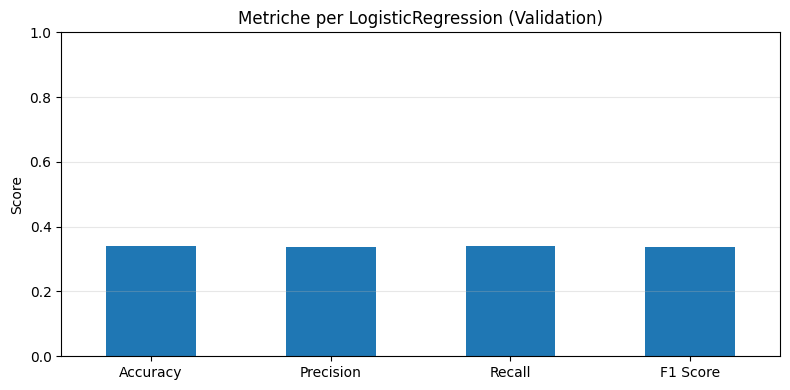


KNN
Accuracy: 0.3133
Precision: 0.3991
Recall: 0.3133
F1 Score: 0.2927


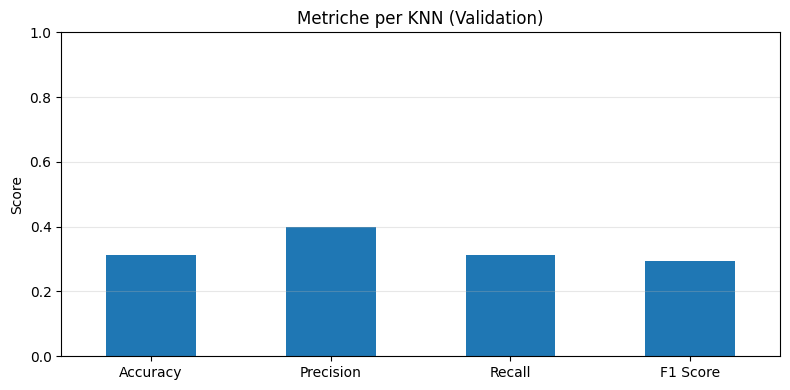


SVM
Accuracy: 0.4392
Precision: 0.4468
Recall: 0.4392
F1 Score: 0.4414


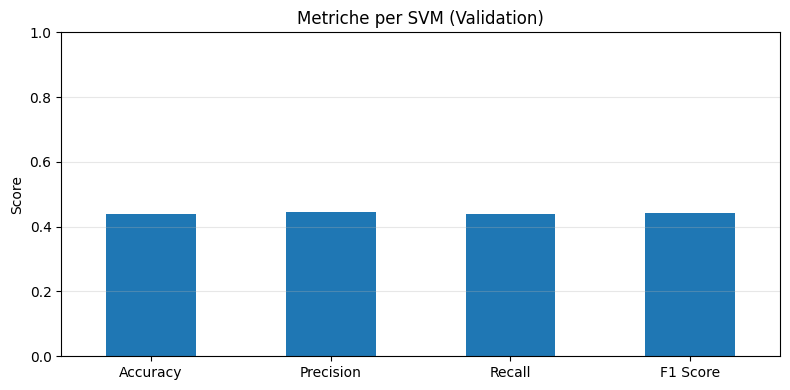


DecisionTree
Accuracy: 0.1517
Precision: 0.1649
Recall: 0.1517
F1 Score: 0.1270


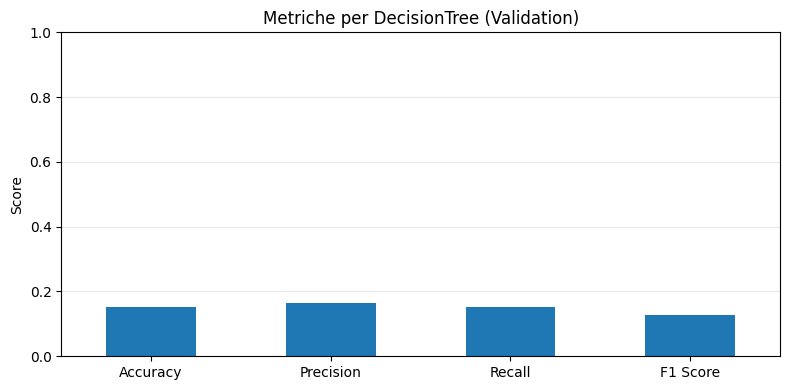


Tabella riepilogo metriche (Validation):


,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.340,0.338,0.340,0.338
KNN,0.313,0.399,0.313,0.293
SVM,0.439,0.447,0.439,0.441
DecisionTree,0.152,0.165,0.152,0.127


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
#Metriche val
print("\n Metriche dettagliate su Validation Set:")
all_metrics = {}

for name, res in results.items():
    model = res['model']
    if model_configs[name]['use_scaling']:
        X_va = X_val_pca
    else:
        X_va = X_val

    
    

    y_pred = model.predict(X_va)

    metrics = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, average='macro'),
        'Recall': recall_score(y_val, y_pred, average='macro'),
        'F1 Score': f1_score(y_val, y_pred, average='macro')
    }

    all_metrics[name] = metrics

    # Visualizzazione
    print(f"\n{name}")
    for m_name, val in metrics.items():
        print(f"{m_name}: {val:.4f}")

    pd.DataFrame.from_dict(metrics, orient='index', columns=[name]).plot(
        kind='bar',
        figsize=(8, 4),
        title=f'Metriche per {name} (Validation)',
        color='#1f77b4',
        legend=False
    )
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
# Tabella riepilogo
print("\nTabella riepilogo metriche (Validation):")
df_metrics = pd.DataFrame(all_metrics).T
display(df_metrics.style.background_gradient(cmap='viridis').format("{:.3f}"))

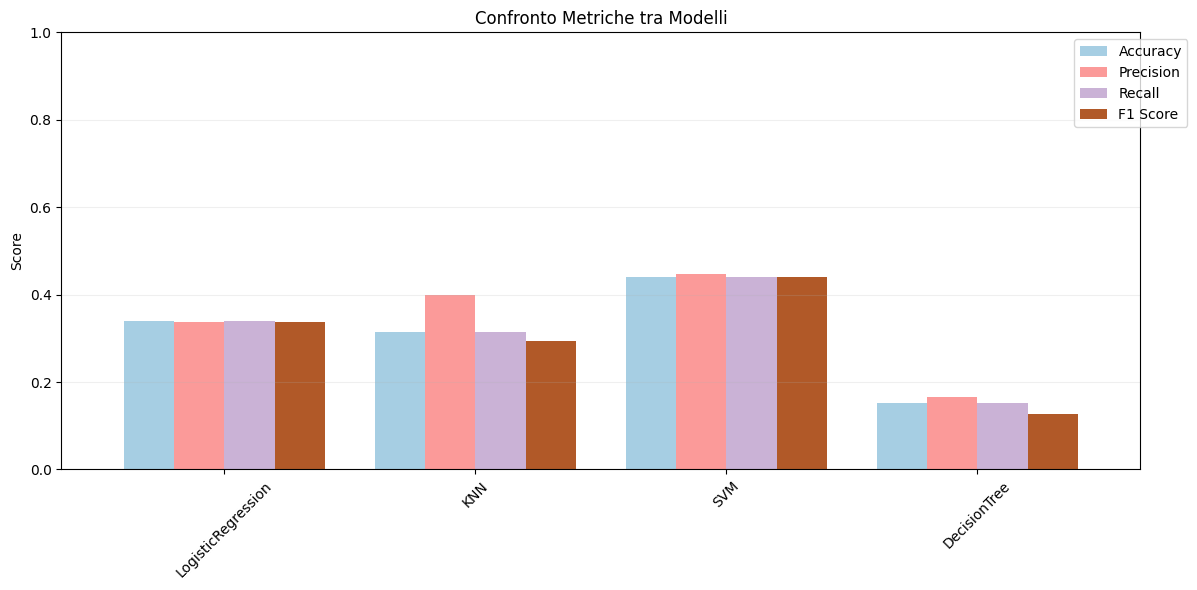

In [9]:
# unico grafico
metrics_df = pd.DataFrame(all_metrics).T

metrics_df.plot(kind='bar', figsize=(12, 6), 
                colormap='Paired', width=0.8)
plt.title('Confronto Metriche tra Modelli')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()